# Inspiration Tree Playground
### This notebook can be used to play with the learned tokens

## (1) Load your root image
### The learned concept should be located under "outputs/\<root_concept>/\<v_i>"

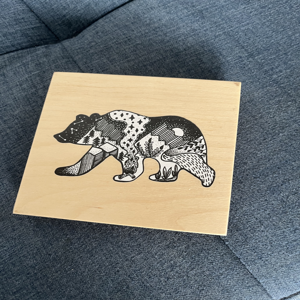

In [78]:
from IPython.display import Image as Image_colab
from IPython.display import display
from PIL import Image
import os

# root_concept = input("Root concept name:")
root_concept = "bear_wooden"
abs_path = os.path.abspath(os.getcwd())
target_ = f"{abs_path}/input_concepts/{root_concept}/v0"
im = Image.open(f"{target_}/{os.listdir(target_)[0]}").resize((300,300))
display(im)

## (2) Load the learned nodes


Loading learned nodes from ['v0', 'v1', 'v2', 'v5', 'v6']...


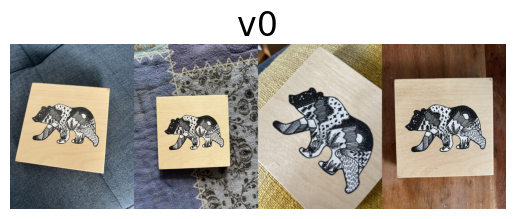

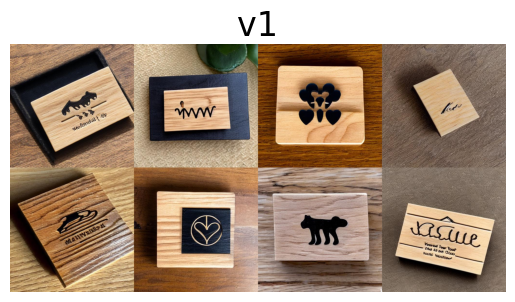

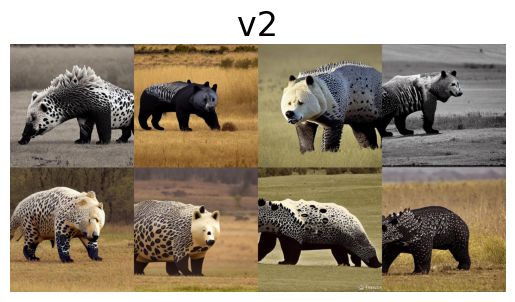

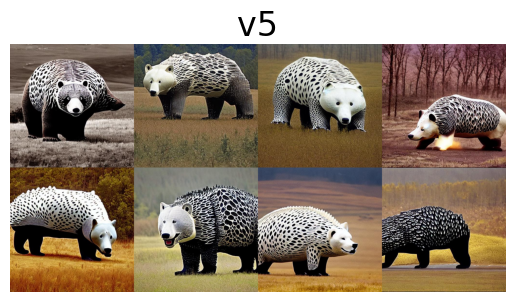

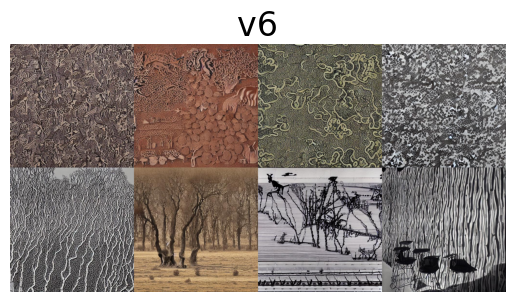

Fetching 15 files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 121927.44it/s]


Prompts loaded to pipe ...
dict_keys(['<v1>', '<v2>', '<v5>', '<v6>'])


In [81]:
import matplotlib.pyplot as plt
import numpy as np 
import glob
import utils
import torch
from diffusers import StableDiffusionPipeline

MODEL_ID = "runwayml/stable-diffusion-v1-5"
device = "cuda" if torch.cuda.is_available() else "cpu"

# read tree
learned_tokens_dir = f"input_concepts/{root_concept}"
learned_nodes = sorted(os.listdir(learned_tokens_dir))
all_nodes = {}
print(f"Loading learned nodes from {learned_nodes}...")
for node in learned_nodes:
    image_paths = glob.glob(f"{learned_tokens_dir}/{node}/*.png") + glob.glob(f"{learned_tokens_dir}/{node}/*.jpg") + glob.glob(f"{learned_tokens_dir}/{node}/*.jpeg")
    if not image_paths:
        continue
    images = [Image.open(p) for p in image_paths]
    plot_stacked = []
    for j in range(int(len(images) / 4)):
        images_staked_h = np.hstack([np.asarray(img) for img in images[j * 4:j * 4 + 4]])
        plot_stacked.append(images_staked_h)

    if len(plot_stacked) == 1:
        im_stack = plot_stacked[0]
    else: 
        im_stack = np.vstack(plot_stacked)
    plt.imshow(im_stack)
    plt.axis("off")
    plt.title(node, size=24)
    plt.show()
    
    if os.path.exists(f"{learned_tokens_dir}/{node}/embeds.bin"):
        node_code = torch.load(f"{learned_tokens_dir}/{node}/embeds.bin")[node]
        all_nodes[f"<{node}>"] = node_code

        
pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=torch.float16, safety_checker=None, requires_safety_checker=False).to(device)
utils.load_tokens(pipe, all_nodes, device)
print("Prompts loaded to pipe ...")
print(all_nodes.keys())

In [108]:
def run_prompt(pipe, prompt, num_images_per_seed, seed=0):
    with torch.no_grad():
        torch.manual_seed(seed)
        images = pipe(prompt=[prompt] * num_images_per_seed, num_inference_steps=25, guidance_scale=7.5).images
        np_images = np.hstack([np.asarray(img) for img in images])
        plt.figure(figsize=(10,10))
        plt.imshow(np_images)
        plt.axis("off")
        plt.title(prompt)
        plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.74it/s]


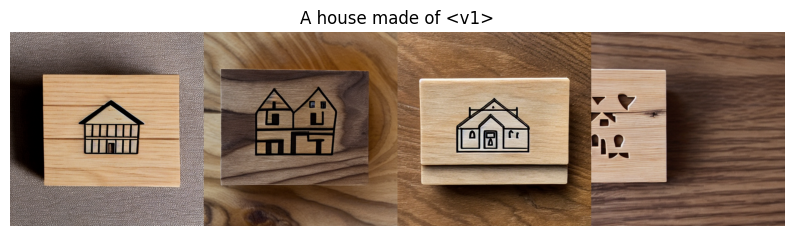

In [88]:
# prompt = input("Insert prompt with the chosen aspect:")
# num_images_per_seed = input("Insert the desired number of images:")
prompt = "A house made of <v1>"
num_images_per_seed = 4
run_prompt(pipe, prompt, num_images_per_seed, seed=0)


# Load other checkpoints
### In case you didn't line the split, you can run again with different seeds, or you can try the codes of differernt interations!
### Below is an example on the Bear, first we show the results of different iterations.
### You can observe the results carefully and <b>choose your favorite iteration</b> (here we chose 100)

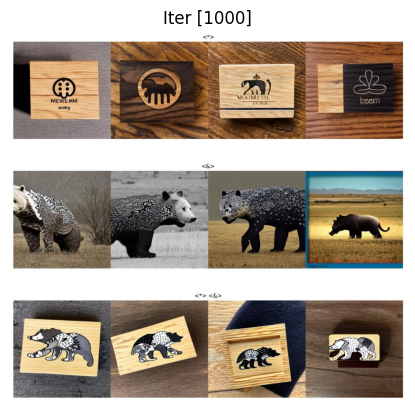

In [106]:
from IPython.display import clear_output
import time

# display all checkpoints
# choose node
# root_concept = input("Root concept name:")
root_concept = "bear_wooden"
# node = input("Choose the node:")
node = "v0"
path_to_res = f"outputs/{root_concept}/{node}"
seeds_scores = torch.load(f"{path_to_res}/consistency_test/seed_scores.bin")
best_seed = max(seeds_scores, key=lambda k: seeds_scores[k])
print(f"Best seed [{best_seed}]")
samples_dir = f"{path_to_res}/{node}_seed{best_seed}/samples"
for k in range(0,1100,100):
    im_ = np.array(Image.open(f"{samples_dir}/{k}.jpg"))
    plt.imshow(im_)
    plt.title(f"Iter [{k}]")
    plt.axis("off")
    plt.show()
    clear_output(wait=True)
    time.sleep(2)

Your chosen iteration: 100


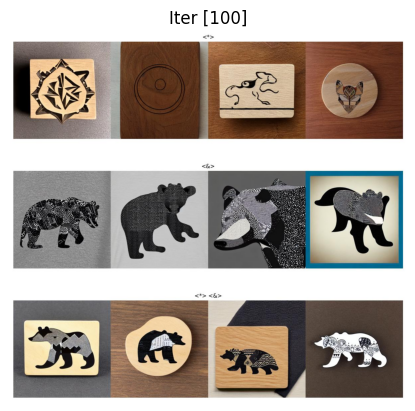

Prompts loaded to pipe ...
dict_keys(['<v0_100l>', '<v0_100r>'])


In [103]:
chosen_iter = input("Your chosen iteration:")
chosen_seed_dir = f"{path_to_res}/{node}_seed{best_seed}/"
im_ = np.array(Image.open(f"{chosen_seed_dir}/samples/{chosen_iter}.jpg"))
plt.imshow(im_)
plt.title(f"Iter [{chosen_iter}]")
plt.axis("off")
plt.show()

learned_nodes = torch.load(f"{chosen_seed_dir}/learned_embeds-steps-{chosen_iter}.bin")
new_nodes = {}
new_nodes[f"<{node}_{chosen_iter}l>"] = learned_nodes["<*>"]
new_nodes[f"<{node}_{chosen_iter}r>"] = learned_nodes["<&>"]
utils.load_tokens(pipe, new_nodes, device)
print("Prompts loaded to pipe ...")
print(new_nodes.keys())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.73it/s]


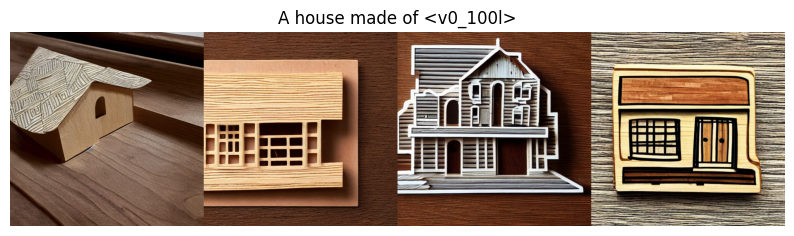

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.84it/s]


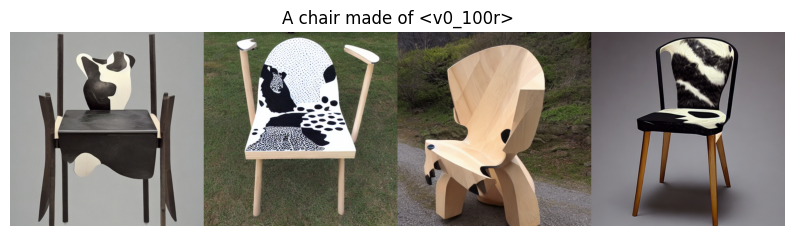

In [112]:
prompt = "A house made of <v0_100l>"
num_images_per_seed = 4
run_prompt(pipe, prompt, num_images_per_seed, seed=1000)

prompt = "A chair made of <v0_100r>"
num_images_per_seed = 4
run_prompt(pipe, prompt, num_images_per_seed, seed=111)